In [25]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

from pyDecision.algorithm.fuzzy_ahp import fuzzy_ahp_method
from pyDecision.algorithm.fuzzy_vikor import fuzzy_vikor_method


In [26]:
df = pd.read_csv("Restaurant Manual Encoded.csv")

ID_col = df["Restaurant ID"]
y = df["Reviews"]
X = df.drop(columns=["Name", "Restaurant ID", "Reviews"])

print(X,"\n")
print(y,"\n")


    Distance (km) from Yuntech              Category  Price Range  \
0                            0                  Cafe            2   
1                            1   Barbeque Restaurant            0   
2                            1    Chinese Restaurant            0   
3                            2  Breakfast Restaurant            0   
4                            3     Brunch Restaurant            0   
5                            3            Restaurant            0   
6                            4            Restaurant            0   
7                            5            Restaurant            0   
8                            6      Asian Restaurant            0   
9                            6    Italian Restaurant            0   
10                           9                  Deli            0   
11                           9       Rice Restaurant            0   
12                           9            Restaurant            0   
13                           9  Fa

In [27]:
num = ["Review Count"]

ord_ = [
    "Distance (km) from Yuntech", "Price Range", "Foot Traffic Level",
    "Accessibility Score", "Visibility from main road", "Storefront Size",
    "Signboard Distinctiveness", "Competition Density", "Operational Hours"
]

nom = [
    "Category",
    "Building Type",
    "Street Location Type",
    "Surrounding Environment"
]


In [28]:
preprocess = ColumnTransformer([
    ("num", RobustScaler(), num),
    ("ord", RobustScaler(), ord_),
    ("nom", OneHotEncoder(drop="first", sparse_output=False), nom)
])

model = Pipeline([
    ("prep", preprocess),
    ("reg", Ridge())
])

model.fit(X, y)

coefs = model.named_steps["reg"].coef_
names = model.named_steps["prep"].get_feature_names_out()

print(coefs,"\n")
print(names,"\n")

[ 0.04598301  0.14730643 -0.01171965  0.10691058  0.12428377  0.09027946
  0.03434373  0.19280247 -0.24519676 -0.02413069  0.03502357 -0.32693189
 -0.20312606 -0.04018102 -0.07914083 -0.06027461 -0.11157722 -0.05538304
 -0.03384899 -0.01772094  0.09264498  0.18529515 -0.06061245  0.23592617
  0.05622401  0.18155389 -0.04797364  0.02235417 -0.04018102 -0.0142656
 -0.05835188 -0.02549379  0.12402669] 

['num__Review Count' 'ord__Distance (km) from Yuntech' 'ord__Price Range'
 'ord__Foot Traffic Level' 'ord__Accessibility Score'
 'ord__Visibility from main road' 'ord__Storefront Size'
 'ord__Signboard Distinctiveness' 'ord__Competition Density'
 'ord__Operational Hours' 'nom__Category_Barbeque Restaurant'
 'nom__Category_Breakfast Restaurant' 'nom__Category_Brunch Restaurant'
 'nom__Category_Cafe' 'nom__Category_Chinese Restaurant'
 'nom__Category_Chophouse Restaurant' 'nom__Category_Deli'
 'nom__Category_Fast Food Restaurant' 'nom__Category_Italian Restaurant'
 'nom__Category_Japanese Re

In [29]:
def minmax(df_):
    return (df_ - df_.min()) / (df_.max() - df_.min())

num_util = minmax(df[num])
ord_util = minmax(df[ord_])

# print(num_util,"\n")
# print(ord_util,"\n")

nom_util = pd.DataFrame(index=df.index)

for c in nom:
    cols = [n for n in names if n.startswith(f"nom__{c}_")]
    print(cols,"\n")
    values = np.zeros(len(df))
    for col in cols:
        cat = col.replace(f"nom__{c}_", "")
        print(cat,"\n")
        values += (df[c] == cat) * coefs[list(names).index(col)]
        print(values,"\n")
    nom_util[c] = values

nom_util = minmax(nom_util)
# print(nom_util,"\n")


['nom__Category_Barbeque Restaurant', 'nom__Category_Breakfast Restaurant', 'nom__Category_Brunch Restaurant', 'nom__Category_Cafe', 'nom__Category_Chinese Restaurant', 'nom__Category_Chophouse Restaurant', 'nom__Category_Deli', 'nom__Category_Fast Food Restaurant', 'nom__Category_Italian Restaurant', 'nom__Category_Japanese Restaurant', 'nom__Category_Korean Restaurant', 'nom__Category_Mandarin Restaurant', 'nom__Category_Meal Delivery', 'nom__Category_Restaurant', 'nom__Category_Rice Restaurant', 'nom__Category_Steak House', 'nom__Category_Taiwanese Restaurant'] 

Barbeque Restaurant 

0     0.000000
1     0.035024
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
Name: Category,

In [30]:
decision_df = pd.concat([num_util, ord_util, nom_util], axis=1)
criteria = decision_df.columns.tolist()

criteria_type = [
    "cost" if c in ["Distance (km) from Yuntech", "Price Range", "Competition Density"]
    else "benefit"
    for c in criteria
]

print(criteria_type)

['benefit', 'cost', 'cost', 'benefit', 'benefit', 'benefit', 'benefit', 'benefit', 'cost', 'benefit', 'benefit', 'benefit', 'benefit', 'benefit']


In [39]:
crit_w = defaultdict(float)

for n, c in zip(names, coefs):
    feat = n.split("__", 1)[1]
    for cr in criteria:
        if feat == cr or feat.startswith(cr + "_"):
            crit_w[cr] += abs(c)
            break

print("crit_w")
print(crit_w,"\n")

w_ml = np.array([crit_w[c] for c in criteria])
w_ml /= w_ml.sum()
print("w_ml")
print(w_ml,"\n")

n = len(criteria)
pcm = np.array([[[w_ml[i] / w_ml[j]] * 3 for j in range(n)] for i in range(n)])
print("pcm")
print(pcm,"\n")

fahp = fuzzy_ahp_method(pcm)[0]
print("fahp")
print(fahp,"\n")
w_fahp = np.array([(l + m + u) / 3 for l, m, u in fahp])
w_fahp /= w_fahp.sum()
print("w_fahp")
print(w_fahp,"\n")

fuzzy_weights = [[
    [0.9 * w, w, 1.1 * w] for w in w_fahp
]]

print("fuzzy_weights")
print(fuzzy_weights,"\n")

crit_w
defaultdict(<class 'float'>, {'Review Count': np.float64(0.04598301339243707), 'Distance (km) from Yuntech': np.float64(0.1473064305586052), 'Price Range': np.float64(0.011719651544727918), 'Foot Traffic Level': np.float64(0.10691057807015084), 'Accessibility Score': np.float64(0.12428377041185945), 'Visibility from main road': np.float64(0.09027945935219844), 'Storefront Size': np.float64(0.03434373460599618), 'Signboard Distinctiveness': np.float64(0.19280247320360122), 'Competition Density': np.float64(0.24519675734125937), 'Operational Hours': np.float64(0.024130685772199553), 'Category': np.float64(1.8234384581836658), 'Building Type': np.float64(0.022354165490649197), 'Street Location Type': np.float64(0.054446619430608086), 'Surrounding Environment': np.float64(0.2078723706064699)}) 

w_ml
[0.01468605 0.0470467  0.00374302 0.03414508 0.03969373 0.02883344
 0.0109687  0.06157722 0.0783109  0.00770685 0.58236945 0.00713947
 0.01738915 0.06639024] 

pcm
[[[1.00000000e+00 1.0

In [32]:
decision_matrix = np.array([
    [[0.9 * v, v, 1.1 * v] for v in row]
    for row in decision_df.values
])

S, R, Q, ranking = fuzzy_vikor_method(
    decision_matrix, fuzzy_weights, criteria_type, graph=False
)

# --- Defuzzify everything ONCE ---
S = np.asarray(S, dtype=float)
R = np.asarray(R, dtype=float)
Q = np.asarray(Q, dtype=float)

if S.ndim == 2:
    S = S.mean(axis=1)
if R.ndim == 2:
    R = R.mean(axis=1)
if Q.ndim == 2:
    Q = Q.mean(axis=1)

ranking = np.asarray(ranking)
if ranking.ndim == 2:
    ranking = ranking[:, -1]


a1: 4.0
a2: 5.0
a3: 20.0
a4: 25.0
a5: 24.0
a6: 14.0
a7: 3.0
a8: 1.0
a9: 11.0
a10: 23.0
a11: 22.0
a12: 10.0
a13: 16.0
a14: 17.0
a15: 9.0
a16: 18.0
a17: 2.0
a18: 12.0
a19: 19.0
a20: 21.0
a21: 6.0
a22: 15.0
a23: 13.0
a24: 7.0
a25: 8.0
a26: 26.0


In [33]:
results = decision_df.copy()
results["Restaurant ID"] = ID_col
results["Q"] = Q
results["Rank"] = ranking


In [34]:
def vikor_sr_plot(S, R, Q, labels):
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(S, R, s=120, c=Q, cmap="viridis", edgecolor="black")

    for i, lbl in enumerate(labels):
        plt.text(S[i], R[i], str(lbl), fontsize=9, ha="right", va="bottom")

    plt.xlabel("S (Group Utility)")
    plt.ylabel("R (Individual Regret)")
    plt.title("VIKOR S–R Compromise Plot")
    plt.colorbar(sc, label="Q (lower = better)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


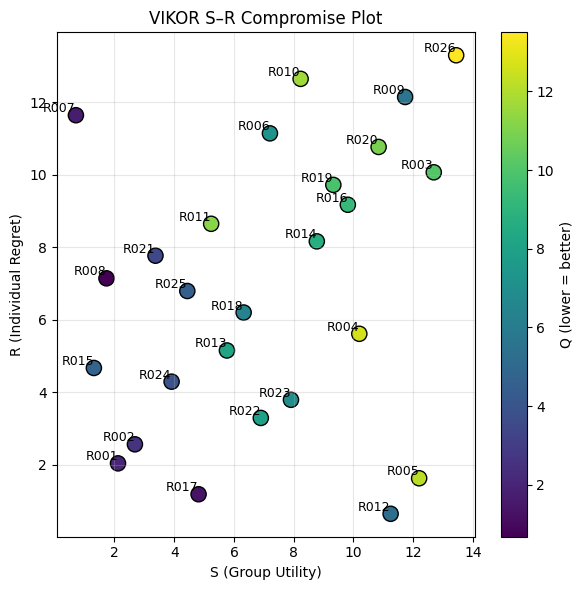

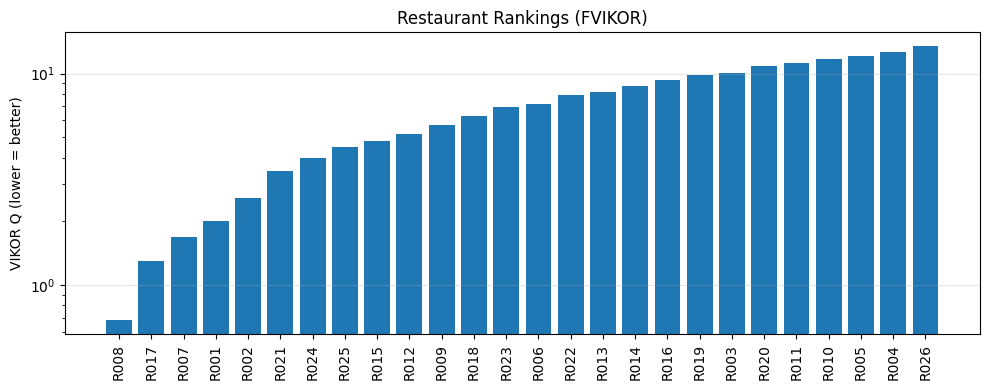

In [35]:
ranked = results.sort_values("Q")

vikor_sr_plot(
    S,
    R,
    Q,
    results["Restaurant ID"]
)

plt.figure(figsize=(10, 4))
plt.bar(ranked["Restaurant ID"].astype(str), ranked["Q"])
plt.xticks(rotation=90)
plt.ylabel("VIKOR Q (lower = better)")
plt.yscale("log")
plt.title("Restaurant Rankings (FVIKOR)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


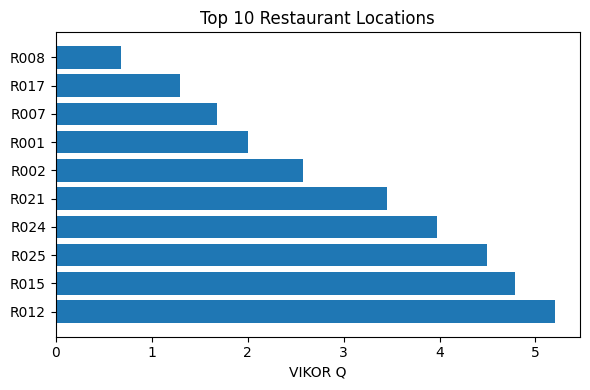

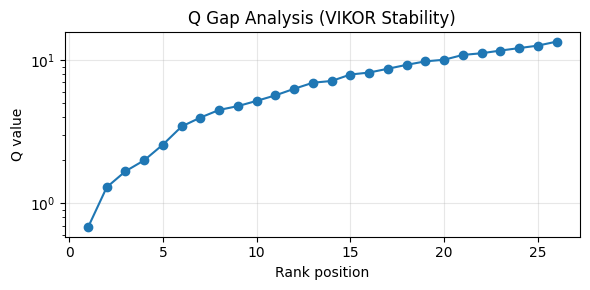

In [36]:
# Top 10 restaurants
top10 = ranked.head(10)

plt.figure(figsize=(6, 4))
plt.barh(
    top10["Restaurant ID"].astype(str),
    top10["Q"]
)
plt.gca().invert_yaxis()
plt.xlabel("VIKOR Q")
plt.title("Top 10 Restaurant Locations")
plt.tight_layout()
plt.show()

# Q gap / stability analysis
plt.figure(figsize=(6, 3))
plt.plot(
    range(1, len(ranked) + 1),
    ranked["Q"],
    marker="o"
)
plt.xlabel("Rank position")
plt.ylabel("Q value")
plt.yscale("log")
plt.title("Q Gap Analysis (VIKOR Stability)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


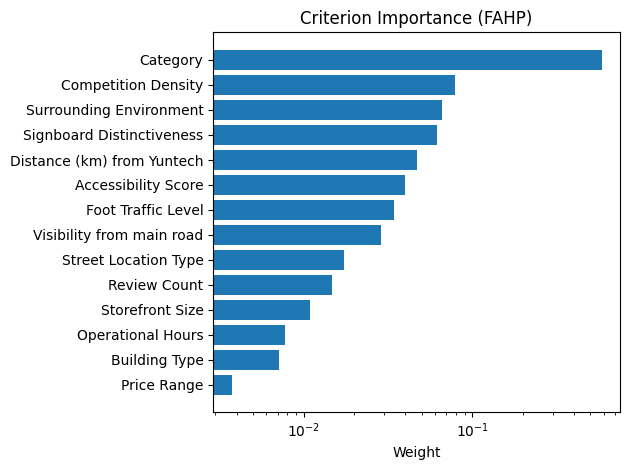

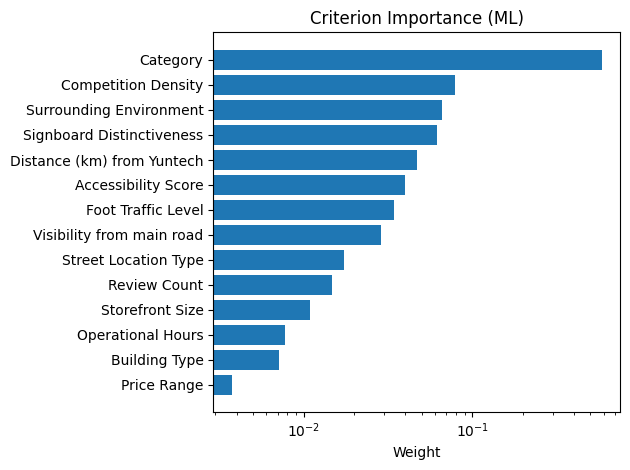

In [37]:
importance_df = pd.DataFrame({
    "Criterion": criteria,
    "ML Weight (|β|)": w_ml,
    "FAHP Weight": w_fahp
}).sort_values("FAHP Weight")


plt.figure()
plt.barh(
    importance_df["Criterion"],
    importance_df["FAHP Weight"]
)
plt.xlabel("Weight")
plt.xscale("log")
plt.title("Criterion Importance (FAHP)")
plt.tight_layout()
plt.show()


plt.figure()
plt.barh(
    importance_df["Criterion"],
    importance_df["ML Weight (|β|)"]
)
plt.xlabel("Weight")
plt.xscale("log")
plt.title("Criterion Importance (ML)")
plt.tight_layout()
plt.show()
